#DownLoad Dataset
**First** we need to download the dataset.

In [1]:
"""## DownLoad Dataset"""

!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz

--2023-05-22 11:15:57--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  53.6MB/s    in 9.0s    

2023-05-22 11:16:06 (42.7 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2023-05-22 11:16:06--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  47.8MB/s    in 7.8s    

2023-05-22 11:16:14 (33.9 MB/s) - ‘test.tar.gz’ saved [276555967/2

#LOAD DATASET
1- Now we should extract the TAR file to folder and load the digitStruct.mat file for each one.

In [2]:
import os
import sys
import tarfile

def extract_tar(filename):
    # remove .tar.gz
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    # if folders already exist then don't extract them 
    if os.path.isdir(root):
        print(root," dir already exist")
    else:
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    # if digitStruct.mat file not exist
    if not os.path.exists(root+'/digitStruct.mat'):
        print("digitStruct.mat  doesn't exist")
    return root + '/digitStruct.mat'

train_digitStruct = extract_tar("train.tar.gz")
test_digitStruct = extract_tar("test.tar.gz")

2- Now we will use h5py library for saving and loading trained models, We created a wrapper for the library to make it more easier to use the  h5py data as an object, then we load the digitStruct.mat file we extracted.

In [3]:
import h5py

class H5pyFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r') # The input h5 matlab file
        self.digitStructName = self.inf['digitStruct']['name'] # The h5 ref to all the file names
        self.digitStructBbox = self.inf['digitStruct']['bbox'] # The h5 ref to all data

    # handles the coding difference when there is exactly one bbox or an array of bbox. 
    def __bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr[j].item()][0][0] for j in range(len(attr))]
        else:
            attr = [attr[0][0]]
        return attr

    def __getDigitStructure(self,n):
        # get a dict of data for the n(th) bbox
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.__bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.__bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.__bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.__bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.__bboxHelper(self.inf[bb]["width"])
        # get the 'name' string for for the n(th) digitStruct. 
        bbox['name'] = ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]]])
        return bbox

    # Return the info about all the images in the dataset
    def getDataInfo(self):
        # returns all the digitStruct from the input file.     
        pictDat = [self.__getDigitStructure(i) for i in range(len(self.digitStructName))]
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

train = H5pyFile(train_digitStruct)
train_data = train.getDataInfo()


test = H5pyFile(test_digitStruct)
test_data = test.getDataInfo()

3- Lets see example of the info of the image 2.png in train folder to get more understanding about what is going on.

We can see that we got the labels(numbers in the image), so we can evaluate the result when we start with the training.
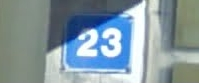

In [4]:
print(train_data[1])

{'filename': '2.png', 'boxes': [{'height': 32.0, 'label': 2.0, 'left': 77.0, 'top': 29.0, 'width': 23.0}, {'height': 32.0, 'label': 3.0, 'left': 98.0, 'top': 25.0, 'width': 26.0}]}


# DEFINITION AND CONVERTION OF THE DATA
1- Now we will build a two Dataset object for each directory where it load the the images and convert them to numpy ndarrays so we can read the images later, we using numpy and PIL to proccess the images.

In [5]:
import numpy as np
from PIL import Image

class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def getDataset(self):
        # init the dataset and labels
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 64, 64), dtype='float32')
        self.labels = np.ones(shape=(len(self.digitStruct), 5), dtype='int') * 10 # 5 labels, 10 represents none
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['filename'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['boxes']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                # get labels individually
                self.labels[i,0:len(boxes)] = [int(j['label']) for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (64, 64)
            region = im.resize(size)
            region = self.normalization(region)
            self.dataset[i,:,:] = region[:,:]
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
        # convert RGB images to greyscale
        im = np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])

        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  

train_dataset = Dataset(train_data, 'train')
train_dataset, train_labels = train_dataset.getDataset()

# remove image number 29929 cuz it have more than 5 numbers, need to import more than 5 numbers later
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

test_dataset = Dataset(test_data, 'test')
test_dataset, test_labels = test_dataset.getDataset()

train/29930.png has more than 5 digits
dataset: (33402, 64, 64)
labels: (33402, 5)
dataset: (13068, 64, 64)
labels: (13068, 5)


2- Now we should build the third dataset(Validation Dataset) to estimate the accuracy of the ML model concerned by spliting the training dataset.


In [6]:
train_portion = 6000
valid_dataset = train_dataset[:train_portion,:,:]
valid_labels = train_labels[:train_portion]
train_dataset = train_dataset[train_portion:,:,:]
train_labels = train_labels[train_portion:]

print("The dataset size after the spliting:")         
print(train_dataset.shape, train_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

The dataset size after the spliting:
(27401, 64, 64) (27401, 5)
(6000, 64, 64) (6000, 5)


3- Now we can see the final results of each image and there labels:

Label for image: [ 9  5 10 10 10]


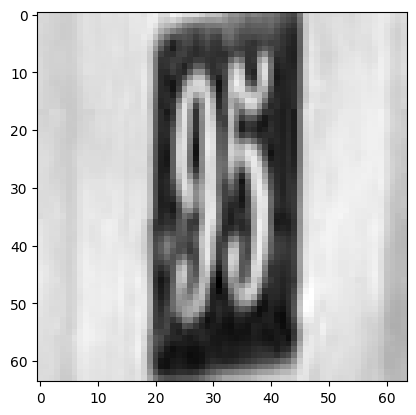

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(train_dataset[101], cmap='gray')

print("Label for image: {}".format(train_labels[101]))

# CONSTRUCTION AND TRAINING THE MODEL
1- now to the hard part, training the model, so first we need to use One-hot encoding technique to get one-hot array from each digit label so the machine learning algorithms can use the data.

In [8]:
from keras.utils import np_utils

possible_classes = 11 # from 0 to 10

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using np_utils from keras to convert, each label is a row in one-hot array
        dig0_arr[index,:] = np_utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = np_utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = np_utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = np_utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = np_utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

# Checking the shape of the OHE array for the first digit position
print(np.shape(train_labels[0]))

(27401, 11)
